# 语义分割：FCN

我们已经学习了如何识别图片里面的主要物体，和找出里面物体的边框。语义分割则在之上更进一步，它对每个像素预测它是否只是背景，还是属于哪个我们感兴趣的物体。

![Semantic Segmentation](../img/catdog_pixel.svg)

可以看到，跟物体检测相比，语义分割预测的边框更加精细。

也许大家还听到过计算机视觉里的一个常用任务：图片分割。它跟语义分割类似，将每个像素划分的某个类。但它跟语义分割不同的时候，图片分割不需要预测每个类具体对应哪个物体。因此图片分割经常只需要利用像素之间的相似度即可，而语义分割则需要详细的类别标号。这也是为什么称其为**语义**的原因。


本章我们将介绍利用卷积神经网络解决语义分割的一个开创性工作之一：[全链接卷积网络](https://arxiv.org/abs/1411.4038)。在此之前我们先了解用来做语义分割的数据。

## 数据集

[VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/)是一个常用的语义分割数据集。输入图片跟之前的数据集类似，但标注也是保存称相应大小的图片来方便查看。下面代码下载这个数据集并解压。注意到压缩包大小是2GB，可以预先下好放置在`data_root`下。

In [1]:
import os
import tarfile
from mxnet import gluon

data_root = '../data'
voc_root = data_root + '/VOCdevkit/VOC2012'
url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
       '/VOCtrainval_11-May-2012.tar')
sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'

fname = gluon.utils.download(url, data_root, sha1_hash=sha1)

if not os.path.isfile(voc_root+'/ImageSets/Segmentation/train.txt'):
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_root)

下面定义函数将训练图片和标注按序读进内存。

In [2]:
from mxnet import image

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + (
        'train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    n = len(images)
    data, label = [None] * n, [None] * n
    for i, fname in enumerate(images):
        data[i] = image.imread('%s/JPEGImages/%s.jpg' % (
            root, fname))
        label[i] = image.imread('%s/SegmentationClass/%s.png' % (
            root, fname))
    return data, label

我们画出前面三张图片和它们对应的标号。在标号中，白色代表边框黑色代表背景，其他不同的颜色对应不同物体。

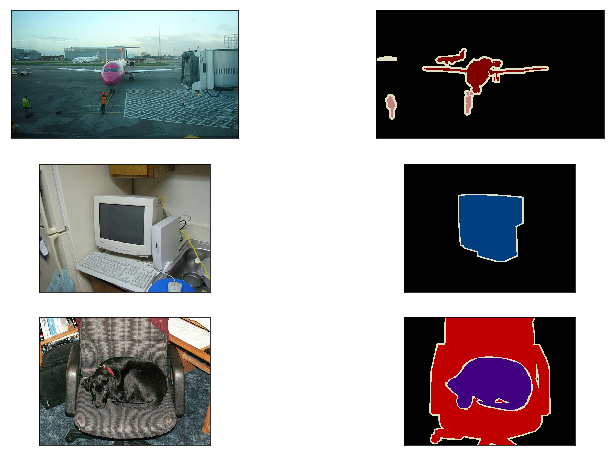

[(281, 500, 3),
 (281, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3)]

In [3]:
import sys
sys.path.append('..')
import utils

train_images, train_labels = read_images()

imgs = []
for i in range(3):
    imgs += [train_images[i], train_labels[i]]

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))
[im.shape for im in imgs]

同时注意到图片的宽度基本是500，但高度各不一样。为了能将多张图片合并成一个批量来加速计算，我们需要输入图片都是同样的大小。之前我们通过`imresize`来将他们调整成同样的大小。但在语义分割里，我们需要对标注做同样的变化来达到像素级别的匹配。但调整大小将改变像素颜色，使得再将它们映射到物体类别变得困难。

这里我们仅仅使用剪切来解决这个问题。就是说对于输入图片，我们随机剪切出一个固定大小的区域，然后对标号图片做同样位置的剪切。

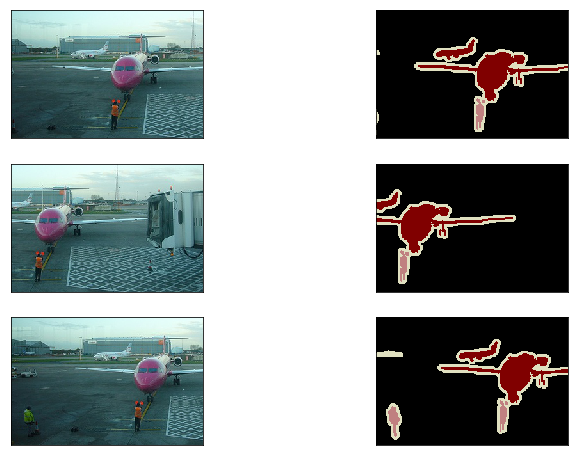

In [4]:
def rand_crop(data, label, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    return data, label

imgs = []
for _ in range(3):
    imgs += rand_crop(train_images[0], train_labels[0],
                      200, 300)

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

接下来我们列出每个物体和背景对应的RGB值

In [5]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

这样给定一个标号图片，我们就可以将每个像素对应的物体标号找出来。

In [6]:
import numpy as np
from mxnet import nd

cm2lbl = np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i

def image2label(im):
    data = im.astype('int32').asnumpy()
    idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return nd.array(cm2lbl[idx])

可以看到第一张训练图片的标号里面属于飞机的像素被标记成了1.

In [7]:
y = image2label(train_labels[0])
y[105:115, 130:140]


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]]
<NDArray 10x10 @cpu(0)>

现在我们可以定义数据读取了。每一次我们将图片和标注随机剪切到要求的形状，并将标注里每个像素转成对应的标号。简单起见我们将小于要求大小的图片全部过滤掉了。

In [8]:
from mxnet import gluon
from mxnet import nd


rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

class VOCSegDataset(gluon.data.Dataset):

    def _filter(self, images):
        return [im for im in images if (
            im.shape[0] >= self.crop_size[0] and
            im.shape[1] >= self.crop_size[1])]

    def __init__(self, train, crop_size):
        self.crop_size = crop_size
        data, label = read_images(train=train)
        data = self._filter(data)
        self.data = [normalize_image(im) for im in data]
        self.label = self._filter(label)
        print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
        data, label = rand_crop(
            self.data[idx], self.label[idx],
            *self.crop_size)
        data = data.transpose((2,0,1))
        label = image2label(label)
        return data, label

    def __len__(self):
        return len(self.data)

我们采用$320\times 480$的大小用来训练，注意到这个比前面我们使用的$224\times 224$要大上很多。但是同样我们将长宽都定义成了32的整数倍。

In [9]:
# height x width
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape)
voc_test = VOCSegDataset(False, input_shape)

Read 1114 examples


Read 1078 examples


最后定义批量读取。可以看到跟之前的不同是批量标号不再是一个向量，而是一个三维数组。

In [10]:
batch_size = 64
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle=True,last_batch='discard')
test_data = gluon.data.DataLoader(
    voc_test, batch_size,last_batch='discard')

for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


## 全连接卷积网络

在数据的处理过程我们看到语义分割跟前面介绍的应用的主要区别在于，预测的标号不再是一个或者几个数字，而是每个像素都需要有标号。在卷积神经网络里，我们通过卷积层和池化层逐渐减少数据长宽但同时增加通道数。例如ResNet18里，我们先将输入长宽减少32倍，由$3\times 224\times 224$的图片转成$512\times 7 \times 7$的输出，应该全局池化层变成$512$长向量，然后最后通过全链接层转成一个长度为$n$的输出向量，这里$n$是类数，既`num_classes`。但在这里，对于输出为$3\times 320 \times 480$的图片，我们需要输出是$n \times 320 \times 480$，就是每个输入像素都需要预测一个长度为$n$的向量。

全连接卷积网络（FCN）的提出是基于这样一个观察。假设$f$是一个卷积层，而且$y=f(x)$。那么在反传求导时，$\partial f(y)$会返回一个跟$x$一样形状的输出。卷积是一个对偶函数，就是$\partial^2 f = f$。那么如果我们想得到跟输入一样的输入，那么定义$g = \partial f$，这样$g(f(x))$就能达到我们想要的。

具体来说，我们定义一个卷积转置层（transposed convolutional, 也经常被错误的叫做deconvolutions），它就是将卷积层的`forward`和`backward`函数兑换。

下面例子里我们看到使用同样的参数，除了替换输入和输出通道数外，`Conv2DTranspose`可以将`nn.Conv2D`的输出还原其输入大小。

In [11]:
from mxnet.gluon import nn

conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)

conv.initialize()
conv_trans.initialize()

x = nd.random.uniform(shape=(1,3,64,64))
y = conv(x)
print('Input:', x.shape)
print('After conv:', y.shape)
print('After transposed conv', conv_trans(y).shape)

Input: (1, 3, 64, 64)
After conv: (1, 10, 32, 32)
After transposed conv (1, 3, 64, 64)


另外一点要注意的是，在最后的卷积层我们同样使用平化层（`nn.Flattern`）或者（全局）池化层来使得方便使用之后的全连接层作为输出。但是这样会损害空间信息，而这个对语义分割很重要。一个解决办法是去掉不需要的池化层，并将全连接层替换成$1\times 1$卷基层。

所以给定一个卷积网络，FCN主要做下面的改动

- 替换全连接层成$1\times 1$卷基
- 去掉过于损失空间信息的池化层，例如全局池化
- 最后接上卷积转置层来得到需要大小的输出
- 为了训练更快，通常权重会初始化称预先训练好的权重

![FCN](../img/fcn.svg)

下面我们基于Resnet18来创建FCN。首先我们下载一个预先训练好的模型。

In [12]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True)

(pretrained_net.features[-4:], pretrained_net.output)

([BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=512),
  Activation(relu),
  GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True),
  Flatten],
 Dense(512 -> 1000, linear))

我们看到`feature`模块最后两层是`GlobalAvgPool2D`和`Flatten`，都是我们不需要的。所以我们定义一个新的网络，它复制除了最后两层的`features`模块的权重。

In [13]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

x = nd.random.uniform(shape=(1,3,*input_shape))
print('Input:', x.shape)
print('Output:', net(x).shape)

Input: (1, 3, 320, 480)
Output: (1, 512, 10, 15)


然后接上一个通道数等于类数的$1\times 1$卷积层。注意到`net`已经将输入长宽减少了32倍。那么我们需要接入一个`strides=32`的卷积转置层。我们使用一个比`stides`大两倍的`kernel`，然后补上适当的填充。

In [14]:
num_classes = len(classes)

with net.name_scope():
    net.add(
        nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,strides=32)
    )

## 训练

训练的时候我们需要初始化新添加的两层。我们可以随机初始化，但实际中发现将卷积转置层初始化成双线性差值函数可以使得训练更容易。

In [15]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros(
        (in_channels, out_channels, kernel_size, kernel_size),
        dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)


下面代码演示这样的初始化等价于对图片进行双线性差值放大。

Input (281, 500, 3)


Output (1124, 2000, 3)


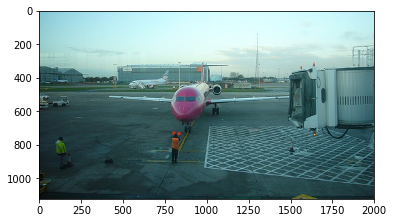

In [16]:
from matplotlib import pyplot as plt

x = train_images[0]
print('Input', x.shape)
x = x.astype('float32').transpose((2,0,1)).expand_dims(axis=0)/255

conv_trans = nn.Conv2DTranspose(
    3, in_channels=3, kernel_size=8, padding=2, strides=4)
conv_trans.initialize()
conv_trans(x)
conv_trans.weight.set_data(bilinear_kernel(3, 3, 8))


y = conv_trans(x)
y = y[0].clip(0,1).transpose((1,2,0))
print('Output', y.shape)

plt.imshow(y.asnumpy())
plt.show()

所以网络的初始化包括了三部分。主体卷积网络从训练好的ResNet18复制得来，替代ResNet18最后全连接的卷积层使用随机初始化。

最后的卷积转置层则使用双线性差值。对于卷积转置层，我们可以自定义一个初始化类。简单起见，这里我们直接通过权重的`set_data`函数改写权重。记得我们介绍过Gluon使用延后初始化来减少构造网络时需要制定输入大小。所以我们先随意初始化它，计算一次`forward`，然后再改写权重。

In [17]:
from mxnet import init

conv_trans = net[-1]
conv_trans.initialize(init=init.Zero())
net[-2].initialize(init=init.Xavier())

x = nd.zeros((batch_size, 3, *input_shape))
net(x)

shape = conv_trans.weight.data().shape
conv_trans.weight.set_data(bilinear_kernel(*shape[0:3]))


这时候我们可以真正开始训练了。值得一提的是我们使用卷积转置层的通道来预测像素的类别。所以在做`softmax`和预测的时候我们需要使用通道这个维度，既维度1. 所以在`SoftmaxCrossEntropyLoss`里加入了额外了`axis=1`选项。其他的部分跟之前的训练一致。

In [18]:
import sys
sys.path.append('..')
import utils

loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)

ctx = utils.try_all_gpus()
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': .1, 'wd':1e-3})

utils.train(train_data, test_data, net, loss,
            trainer, ctx, num_epochs=10)

Start training on  [gpu(0), gpu(1)]


Epoch 0. Loss: 1.500, Train acc 0.73, Test acc 0.82, Time 73.1 sec


Epoch 1. Loss: 0.590, Train acc 0.83, Test acc 0.84, Time 34.9 sec


Epoch 2. Loss: 0.465, Train acc 0.86, Test acc 0.84, Time 34.9 sec


Epoch 3. Loss: 0.386, Train acc 0.88, Test acc 0.84, Time 34.9 sec


Epoch 4. Loss: 0.360, Train acc 0.88, Test acc 0.85, Time 34.8 sec


Epoch 5. Loss: 0.320, Train acc 0.90, Test acc 0.85, Time 34.8 sec


Epoch 6. Loss: 0.296, Train acc 0.90, Test acc 0.84, Time 34.8 sec


Epoch 7. Loss: 0.279, Train acc 0.91, Test acc 0.86, Time 34.8 sec


Epoch 8. Loss: 0.255, Train acc 0.91, Test acc 0.86, Time 34.8 sec


Epoch 9. Loss: 0.241, Train acc 0.92, Test acc 0.86, Time 34.8 sec


## 预测

预测函数跟之前的图片分类预测类似，但跟上面一样，主要不同在于我们需要在`axis=1`上做`argmax`. 同时我们定义`image2label`的反函数，它将预测值转成图片。

In [19]:
def predict(im):
    data = normalize_image(im)
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    yhat = net(data.as_in_context(ctx[0]))
    pred = nd.argmax(yhat, axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

def label2image(pred):
    x = pred.astype('int32').asnumpy()
    cm = np.array(colormap).astype('uint8')
    return nd.array(cm[x,:])

我们读取前几张测试图片并对其进行预测。

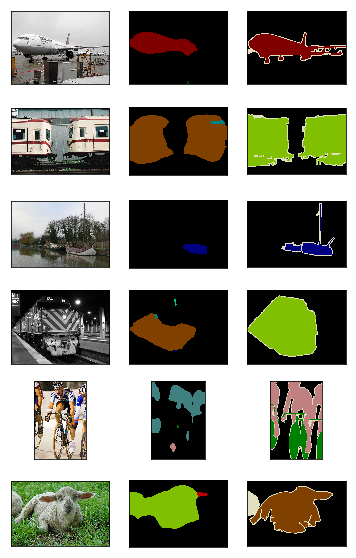

In [20]:
test_images, test_labels = read_images(train=False)

n = 6
imgs = []
for i in range(n):
    x = test_images[i]
    pred = label2image(predict(x))
    imgs += [x, pred, test_labels[i]]

utils.show_images(imgs, nrows=n, ncols=3, figsize=(6,10))

## 总结

通过使用卷积转置层，我们可以得到更大分辨率的输出。

## 练习

1. 试着改改最后的卷积转置层的参数设定
1. 看看双线性差值初始化是不是必要的
1. 试着改改训练参数来使得收敛更好些
1. [FCN论文](https://arxiv.org/abs/1411.4038)中提到了不只是使用主体卷积网络输出，还可以将前面层的输出也加进来。试着实现。


**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/3041)